In [2]:
import psycopg2
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import xgboost
import catboost
import lightgbm
import optuna

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, log_loss
from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFE

from xgboost import XGBClassifier, plot_importance
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier, plot_importance
from optuna.integration import CatBoostPruningCallback, XGBoostPruningCallback, LightGBMPruningCallback


pd.set_option('display.max_columns', None)
random_state = 42

#### Query data from PostgreSQL table, save to csv

In [2]:
conn = psycopg2.connect(host="localhost", dbname='cs', user='postgres', password='123456', port=5432)
cur = conn.cursor()

query = """SELECT * FROM side_dataset where id>=684"""
cur.execute(query)

rows = cur.fetchall()
columns = [desc[0] for desc in cur.description]
df = pd.DataFrame(rows, columns=columns)

cur.close()
conn.close()

df.to_csv('df_693.csv')

#### Begin

In [56]:
data = pd.read_csv('df_693.csv')
#First 4 rows are not needed
df = data.iloc[:,5:]

#### While parsing the data, I was storing this particular stat (average rounds lost(won) on a map) as 0's in case of missing data. So, I convert them to NULL, to deal with them further. Also deleting the rows with incorrect data

In [57]:
df.loc[(df['t1_rounds_lost']>0) & (df['t1_rounds_won'] == 0), 't1_rounds_won'] = None
df.loc[(df['t1_rounds_lost']==0) & (df['t1_rounds_won'] > 0), 't1_rounds_lost'] = None
df.loc[(df['t2_rounds_lost']==0) & (df['t2_rounds_won'] > 0), 't2_rounds_lost'] = None
df.loc[(df['t2_rounds_lost']>0) & (df['t2_rounds_won'] == 0), 't2_rounds_won'] = None

df.drop(df[(df['t2_5v4']==0) & (df['t2_played']>0)].index, axis=0, inplace=True)
df.drop(df[(df['t1_5v4']==0) & (df['t1_played']>0)].index, axis=0, inplace=True)

#### Try filling NULL values with -1's and calues with rounds_lost, rounds_won > 13 to 13

In [58]:
df.loc[df['t1_rounds_lost']>13,'t1_rounds_lost'] = 13
df.loc[df['t2_rounds_lost']>13,'t2_rounds_lost'] = 13
df.loc[df['t1_rounds_won']>13,'t1_rounds_won'] = 13
df.loc[df['t2_rounds_won']>13,'t2_rounds_won'] = 13

df['t1_rounds_lost'].fillna(15, inplace=True)
df['t1_rounds_won'].fillna(15, inplace=True)
df['t2_rounds_lost'].fillna(15, inplace=True)
df['t2_rounds_won'].fillna(15, inplace=True)

### Experiment 1. The differences between team stats will be the predicting features, so creating the features

In [59]:
cols_name = [df.columns[i]+'_dif' for i in range(0,len(df.columns[:22]),2)] + [df.columns[i]+'_dif' for i in range(22, 24)] + [df.columns[i]+'_dif' for i in range(25, 33)]

dataset = pd.DataFrame(columns=cols_name)

for index, name in enumerate(cols_name[:11]):
    dataset[name] = df[df.columns[index*2]] - df[df.columns[index*2+1]]

for index, name in enumerate(cols_name[11:13]):
    dataset[name] = df[df.columns[22+index]] - df[df.columns[33+index]]

for index, name in enumerate(cols_name[13:]):
    dataset[name] = df[df.columns[25+index]] - df[df.columns[36+index]]

dataset['fp_diff'] = df['t1_fp'].astype('int') - df['t2_fp'].astype('int')
dataset['result'] = df['result']

dataset.to_csv('diffs.csv', index=False)

#### Preparing data

In [78]:
scaler = StandardScaler()

columns = ['t1_winstreak_dif','t1_h2h_dif','t1_ranking_dif','t1_pluses_dif','t1_minuses_dif','t1_coef_dif','t1_rating_dif','t1_event_rating_dif', \
            't1_num_maps_dif','t1_avg_lost_dif','t1_avg_won_dif','t1_rounds_lost_dif','t1_rounds_won_dif','t1_fp_percent_dif','t1_winrate_dif', \
            't1_played_dif','t1_map_winstreak_dif','t1_map_losestreak_dif','t1_5v4_dif','t1_4v5_dif','t1_pistol_dif']

scaler.fit(dataset.loc[:,columns])
dataset.loc[:,columns] = scaler.transform(dataset.loc[:,columns])

with open('scaler.pkl','wb') as f:
    pickle.dump(scaler, f)

dataset.to_csv('just_scaled.csv', index=False)

In [56]:
dataset = pd.read_csv('just_scaled.csv')

Y = dataset.loc[:,['result']]
X = dataset.drop('result',axis=1)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=100, shuffle=True, random_state=42)
# x_val, x_test, y_val, y_test = train_test_split(x_rest, y_rest, test_size=100, shuffle=True, random_state=42)
print(x_train.shape)
# print(x_val.shape)
print(x_test.shape)

(519, 22)
(100, 22)


#### Modelling

In [57]:
defaults = pd.DataFrame([['XGBoost',0],['CatBoost',0],['LightGBM',0]],columns=['clf_name', 'clf_accuracy'])
models = [XGBClassifier(random_state=random_state), CatBoostClassifier(random_state=random_state, verbose=0), LGBMClassifier(random_state=random_state)]

cv = KFold(n_splits=5)

for index, model in enumerate(models):
    accuracies = []  # List to store the accuracy of each fold
    for train_index, test_index in cv.split(x_train):
        fx_train, fx_test = x_train.iloc[train_index], x_train.iloc[test_index]
        fy_train, fy_test = y_train.iloc[train_index], y_train.iloc[test_index]

        model.fit(fx_train, fy_train.values.ravel())

        preds = model.predict(fx_test)

        if index == 1:
            preds = [True if item=='True' else False for item in model.predict(fx_test)]

        accuracies.append(accuracy_score(fy_test, preds))
    
    mean_accuracy = np.mean(accuracies)
    defaults.loc[index, 'clf_accuracy'] = mean_accuracy

defaults.sort_values(by='clf_accuracy', ascending=False).head()

,clf_name,clf_accuracy
1,CatBoost,0.564470
2,LightGBM,0.547386
0,XGBoost,0.506833


#### Finetuning

In [ ]:
def cb_objective(trial, X, y):
    param_grid = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "depth": trial.suggest_int("max_depth", 3, 12),
        #"min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 300, step=1),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 0, 20, step=1),
        "colsample_bylevel": trial.suggest_float(
            "colsample_bylevel", 0.5, 1, step=0.1
        ),
        "subsample": trial.suggest_float("subsample", 0.5, 1, step=0.1),
        "random_strength": trial.suggest_float("random_strength", 0, 1, step=0.1),
        #"grow_policy": trial.suggest_categorical("grow_policy", ["SymmetricTree"]),
        "bagging_temperature": trial.suggest_float('bagging_temperature', 0, 20, step=0.25)
    }

    cv = KFold(n_splits=5)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = CatBoostClassifier(
                              **param_grid,
                              iterations=10000,
                              loss_function='Logloss',
                              random_seed=42,
                              early_stopping_rounds=50,
                              eval_metric='Accuracy',
                              verbose=0
                              )
 
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            verbose=False,
        )
        preds = [True if item=='True' else False for item in model.predict(X_test)]
        cv_scores[idx] = accuracy_score(y_test, preds)

    return np.mean(cv_scores)

study = optuna.create_study(direction="maximize", study_name="CB Classifier")
func = lambda trial: cb_objective(trial, x_train, np.ravel(y_train.values))
study.optimize(func, n_trials=100)

print(f"\tBest value : {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

Best value : 0.65317
	Best params:
		learning_rate: 0.13803526386053072
		max_depth: 4
		l2_leaf_reg: 19
		colsample_bylevel: 1.0
		subsample: 0.7
		random_strength: 1.0
		bagging_temperature: 4.5

In [ ]:
def xgb_objective(trial, X, y):
    param_grid = {
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "eta": trial.suggest_float("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_weight": trial.suggest_int("min_child_weight", 0, 10, step=1),
        "reg_lambda": trial.suggest_int("reg_lambda", 0, 20, step=2),
        "reg_alpha": trial.suggest_int("reg_alpha", 0, 20, step=2),
        "gamma": trial.suggest_int("gamma", 0, 10, step=1),
        "colsample_bytree": trial.suggest_float(
            "colsample_bytree", 0.5, 1, step=0.1
        ),
        "subsample": trial.suggest_float("subsample", 0.5, 1, step=0.1),
    }

    cv = KFold(n_splits=5)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = XGBClassifier(objective='binary:logistic', **param_grid, early_stopping_rounds=50, eval_metric="logloss", verbosity=0, n_jobs=4, random_state=42)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            verbose=False,
        )
        preds = model.predict_proba(X_test)
        cv_scores[idx] = log_loss(y_test, preds)

    return np.mean(cv_scores)

study = optuna.create_study(direction="minimize", study_name="XGB Classifier")
func = lambda trial: xgb_objective(trial, x_train, np.ravel(y_train.values))
study.optimize(func, n_trials=200)

print(f"\tBest value: {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

Best value: 0.66288
	Best params:
		n_estimators: 10000
		learning_rate: 0.22707789895194652
		max_depth: 3
		min_child_weight: 2
		reg_lambda: 14
		reg_alpha: 8
		gamma: 0
		colsample_bytree: 0.9
		subsample: 0.5

In [ ]:
def lgb_objective(trial, X, y):
    param_grid = {
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 30),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 20),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 20),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.6, 1, step=0.1
        ),
        "bagging_freq": trial.suggest_int("bagging_freq", 5, 50, step=5),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.6, 1, step=0.1
        ),
        "subsample": trial.suggest_float("subsample", 0.6, 1, step=0.1)
    }

    cv = KFold(n_splits=5)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = LGBMClassifier(objective="binary", **param_grid, random_state=42, verbosity=-1, early_stopping_rounds=50)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="binary_error",
            verbose=False
        )
        preds = model.predict(X_test)
        cv_scores[idx] = accuracy_score(y_test, preds)

    return np.mean(cv_scores)

study = optuna.create_study(direction="maximize", study_name="LGBM Classifier")
func = lambda trial: lgb_objective(trial, x_train, np.ravel(y_train.values))
study.optimize(func, n_trials=100)

print(f"\tBest value: {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

Best value: 0.63010
	Best params:
		n_estimators: 10000
		learning_rate: 0.2314223134242193
		num_leaves: 2020
		max_depth: 3
		min_data_in_leaf: 4
		lambda_l1: 0
		lambda_l2: 5
		min_gain_to_split: 0.6299949073662396
		bagging_fraction: 1.0
		bagging_freq: 45
		feature_fraction: 0.8
		subsample: 0.6

#### Finding the optimal number of n_estimators for the chosen hyperparameters

In [15]:
# XGBOOST
model = XGBClassifier(
        objective='binary:logistic', 
        n_estimators= 10000,
		learning_rate= 0.23007977663979073,
		max_depth= 11,
		min_child_weight= 8,
		reg_lambda= 0,
		reg_alpha= 0,
		gamma= 5,
		colsample_bytree= 0.6,
		subsample= 0.6,
        early_stopping_rounds=50,
        eval_metric="logloss",
        verbosity=0,
        n_jobs=4,
        random_state=42
    )

cv = KFold(n_splits=5)
iters = np.empty(5)

for idx, (train_idx, test_idx) in enumerate(cv.split(x_train, y_train)):
    fx_train, fx_test = x_train.iloc[train_idx], x_train.iloc[test_idx]
    fy_train, fy_test = y_train.iloc[train_idx], y_train.iloc[test_idx]

    model.fit(
        fx_train,
        fy_train,
        eval_set=[(fx_test, fy_test)],
        verbose=False,
    )
    iters[idx] = model.best_iteration

xgb_iters = np.mean(iters)
print(xgb_iters)

14.8


In [3]:
#CatBoost
model = CatBoostClassifier(
        learning_rate= 0.13803526386053072,
		max_depth= 4,
		l2_leaf_reg= 19,
		colsample_bylevel= 1.0,
		subsample= 0.7,
		random_strength= 1.0,
		bagging_temperature= 4.5,
        iterations=10000,
        loss_function='Logloss',
        random_seed=42,
        early_stopping_rounds=50,
        eval_metric='Accuracy',
        verbose=0
        )

cv = KFold(n_splits=5)
iters = np.empty(5)

for idx, (train_idx, test_idx) in enumerate(cv.split(x_train, y_train)):
    fx_train, fx_test = x_train.iloc[train_idx], x_train.iloc[test_idx]
    fy_train, fy_test = y_train.iloc[train_idx], y_train.iloc[test_idx]

    model.fit(
        fx_train,
        fy_train,
        eval_set=[(fx_test, fy_test)],
        verbose=False,
    )
    iters[idx] = model.get_best_iteration()

cb_iters = np.mean(iters)
print(cb_iters)

19.6


In [ ]:
#LGB
model = LGBMClassifier(
        objective="binary", 
        random_state=42, 
        verbosity=-1, 
        early_stopping_rounds=50,
        n_estimators=10000,
		learning_rate=0.2314223134242193,
		num_leaves=2020,
		max_depth=3,
		min_data_in_leaf=4,
		lambda_l1=0,
		lambda_l2=5,
		min_gain_to_split=0.6299949073662396,
		bagging_fraction=1.0,
		bagging_freq=45,
		feature_fraction=0.8,
		subsample=0.6
        )

cv = KFold(n_splits=5)
iters = np.empty(5)

for idx, (train_idx, test_idx) in enumerate(cv.split(x_train, y_train)):
    fx_train, fx_test = x_train.iloc[train_idx], x_train.iloc[test_idx]
    fy_train, fy_test = y_train.iloc[train_idx], y_train.iloc[test_idx]

    model.fit(
        fx_train,
        fy_train,
        eval_set=[(fx_test, fy_test)],
        eval_metric="binary_error",
        verbose=False,
    )
    iters[idx] = model.best_iteration_

lgb_iters = np.mean(iters)
print(lgb_iters)

In [7]:
print(lgb_iters)

8.0


#### Testing on test set

In [18]:
xgb = XGBClassifier(
        objective='binary:logistic', 
        n_estimators= 15,
		learning_rate= 0.23007977663979073,
		max_depth= 11,
		min_child_weight= 8,
		reg_lambda= 0,
		reg_alpha= 0,
		gamma= 5,
		colsample_bytree= 0.6,
		subsample= 0.6,
        verbosity=0,
        n_jobs=4,
        random_state=42
    )

xgb.fit(x_train, y_train, verbose=False)
preds = xgb.predict(x_test)
print(accuracy_score(y_test, preds))

0.54


In [8]:
cb = CatBoostClassifier(
        learning_rate= 0.13803526386053072,
		max_depth= 4,
		l2_leaf_reg= 19,
		colsample_bylevel= 1.0,
		subsample= 0.7,
		random_strength= 1.0,
		bagging_temperature= 4.5,
        iterations=20,
        loss_function='Logloss',
        random_seed=42,
        verbose=0
)   

cb.fit(x_train, y_train, verbose=False)
preds = [True if item=='True' else False for item in cb.predict(x_test)]
print(accuracy_score(y_test, preds))

0.56


In [9]:
lgb = LGBMClassifier(
        objective="binary", 
        random_state=42, 
        verbosity=-1, 
        n_estimators=8,
		learning_rate=0.2314223134242193,
		num_leaves=2020,
		max_depth=3,
		min_data_in_leaf=4,
		lambda_l1=0,
		lambda_l2=5,
		min_gain_to_split=0.6299949073662396,
		bagging_fraction=1.0,
		bagging_freq=45,
		feature_fraction=0.8,
		subsample=0.6
)

lgb.fit(x_train, y_train.values.ravel())
preds = lgb.predict(x_test)
print(accuracy_score(y_test, preds))

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_gain_to_split is set=0.6299949073662396, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6299949073662396
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=0.6 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] bagging_freq is set=45, subsample_freq=0 will be ignored. Current value: bagging_freq=45
0.56


#### Feature importance

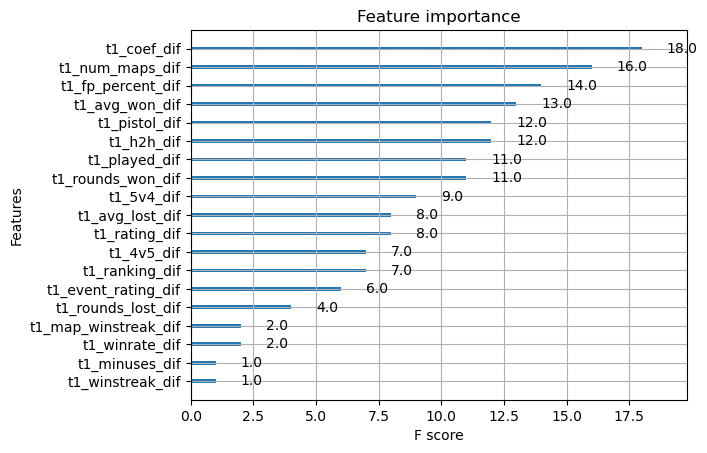

In [12]:
#XGBoost
plot_importance(xgb)
plt.show()

In [14]:
#CatBoost
feature_importances = cb.get_feature_importance()
feature_names = cb.feature_names_
importances = sorted(zip(feature_names, feature_importances), key=lambda x: x[1], reverse=True)
print(importances)

[('t1_coef_dif', 16.98071865823163), ('t1_avg_won_dif', 11.373770785490676), ('t1_avg_lost_dif', 8.415125857511859), ('t1_pistol_dif', 7.293936827435082), ('t1_played_dif', 6.985897703911737), ('t1_rating_dif', 6.965695874501395), ('t1_pluses_dif', 6.8823118997934785), ('t1_rounds_won_dif', 6.659640941854887), ('t1_fp_percent_dif', 6.020925966431849), ('t1_5v4_dif', 4.8136615343002855), ('t1_num_maps_dif', 4.17496593031647), ('t1_event_rating_dif', 4.08382010883435), ('t1_4v5_dif', 1.9920463265332118), ('t1_ranking_dif', 1.963934106870584), ('t1_rounds_lost_dif', 1.8382961849354733), ('t1_winrate_dif', 1.5861924768493365), ('t1_h2h_dif', 1.5030639495647973), ('t1_winstreak_dif', 0.27413972433970435), ('t1_map_winstreak_dif', 0.17023534246515698), ('t1_map_losestreak_dif', 0.021619799828046318), ('t1_minuses_dif', 0.0), ('t1_fp', 0.0), ('t2_fp', 0.0)]


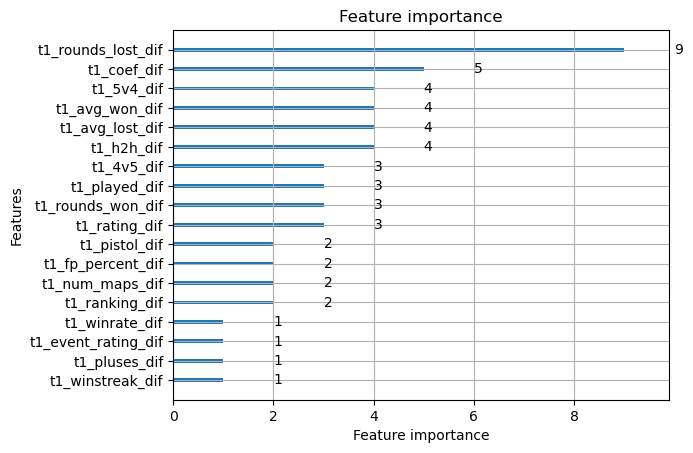

In [17]:
#LightGBM
plot_importance(lgb)
plt.show()

### Experiment 2. All features + differences

#### Prepare data

In [6]:
cols_name = [df.columns[i]+'_dif' for i in range(0,len(df.columns[:22]),2)] + [df.columns[i]+'_dif' for i in range(22, 24)] + [df.columns[i]+'_dif' for i in range(25, 33)]

for index, name in enumerate(cols_name[:11]):
    df[name] = df[df.columns[index*2]] - df[df.columns[index*2+1]]

for index, name in enumerate(cols_name[11:13]):
    df[name] = df[df.columns[22+index]] - df[df.columns[33+index]]

for index, name in enumerate(cols_name[13:]):
    df[name] = df[df.columns[25+index]] - df[df.columns[36+index]]

df.to_csv('all+diffs.csv',index=False)

In [18]:
dataset = pd.read_csv('all+diffs.csv')

Y = dataset.loc[:,'result']
X = dataset.drop('result',axis=1)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=100, shuffle=True, random_state=42)
print(x_train.shape)
print(x_test.shape)

(519, 65)
(100, 65)


#### Modelling

In [18]:
defaults = pd.DataFrame([['XGBoost',0],['CatBoost',0],['LightGBM',0]],columns=['clf_name', 'clf_accuracy'])
models = [XGBClassifier(random_state=random_state), CatBoostClassifier(random_state=random_state, verbose=0), LGBMClassifier(random_state=random_state)]

cv = KFold(n_splits=5)

for index, model in enumerate(models):
    accuracies = []  # List to store the accuracy of each fold
    for train_index, test_index in cv.split(x_train):
        fx_train, fx_test = x_train.iloc[train_index], x_train.iloc[test_index]
        fy_train, fy_test = y_train.iloc[train_index], y_train.iloc[test_index]

        model.fit(fx_train, fy_train.values.ravel())

        preds = model.predict(fx_test)

        if index == 1:
            preds = [True if item=='True' else False for item in model.predict(fx_test)]

        accuracies.append(accuracy_score(fy_test, preds))
    
    mean_accuracy = np.mean(accuracies)
    defaults.loc[index, 'clf_accuracy'] = mean_accuracy

defaults.sort_values(by='clf_accuracy', ascending=False).head()

,clf_name,clf_accuracy
1,CatBoost,0.591561
2,LightGBM,0.549160
0,XGBoost,0.537640


#### Fine-tuning

In [ ]:
#CatBoost
def cb_objective(trial, X, y):
    param_grid = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 50, step=1),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 0, 20, step=1),
        "colsample_bylevel": trial.suggest_float(
            "colsample_bylevel", 0.5, 1, step=0.1
        ),
        "subsample": trial.suggest_float("subsample", 0.5, 1, step=0.1),
        "random_strength": trial.suggest_float("random_strength", 0, 1, step=0.1),
        #"grow_policy": trial.suggest_categorical("grow_policy", ["SymmetricTree"]),
        "bagging_temperature": trial.suggest_float('bagging_temperature', 0, 20, step=0.25)
    }

    cv = KFold(n_splits=5)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = CatBoostClassifier(
                              **param_grid,
                              iterations=10000,
                              loss_function='Logloss',
                              random_seed=42,
                              early_stopping_rounds=50,
                              eval_metric='Accuracy',
                              verbose=0
                              )
 
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            verbose=False,
        )
        preds = [True if item=='True' else False for item in model.predict(X_test)]
        cv_scores[idx] = accuracy_score(y_test, preds)

    return np.mean(cv_scores)

study = optuna.create_study(direction="maximize", study_name="CB Classifier")
func = lambda trial: cb_objective(trial, x_train, np.ravel(y_train.values))
study.optimize(func, n_trials=200)

print(f"\tBest value : {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

Best value : 0.65902
	Best params:
		learning_rate: 0.05351839411162072
		max_depth: 4
		min_data_in_leaf: 31
		l2_leaf_reg: 3
		colsample_bylevel: 1.0
		subsample: 0.5
		random_strength: 0.8
		bagging_temperature: 10.25

In [ ]:
#XGBoost
def xgb_objective(trial, X, y):
    param_grid = {
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "eta": trial.suggest_float("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_weight": trial.suggest_int("min_child_weight", 0, 10, step=1),
        "reg_lambda": trial.suggest_int("reg_lambda", 0, 20, step=2),
        "reg_alpha": trial.suggest_int("reg_alpha", 0, 20, step=2),
        "gamma": trial.suggest_int("gamma", 0, 10, step=1),
        "colsample_bytree": trial.suggest_float(
            "colsample_bytree", 0.5, 1, step=0.1
        ),
        "subsample": trial.suggest_float("subsample", 0.5, 1, step=0.1),
    }

    cv = KFold(n_splits=5)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = XGBClassifier(objective='binary:logistic', **param_grid, early_stopping_rounds=50, eval_metric="error", verbosity=0, n_jobs=4, random_state=42)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            verbose=False,
        )
        preds = model.predict(X_test)
        cv_scores[idx] = accuracy_score(y_test, preds)

    return np.mean(cv_scores)

study = optuna.create_study(direction="maximize", study_name="XGB Classifier")
func = lambda trial: xgb_objective(trial, x_train, np.ravel(y_train.values))
study.optimize(func, n_trials=200)

print(f"\tBest value: {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

Best value: 0.64554
	Best params:
		n_estimators: 10000
		learning_rate: 0.060726041010120094
		max_depth: 4
		min_child_weight: 9
		reg_lambda: 2
		reg_alpha: 0
		gamma: 2
		colsample_bytree: 0.6
		subsample: 0.5

In [ ]:
#LGBClassifier
def lgb_objective(trial, X, y):
    param_grid = {
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 30),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 20),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 20),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.6, 1, step=0.1
        ),
        "bagging_freq": trial.suggest_int("bagging_freq", 5, 50, step=5),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.6, 1, step=0.1
        ),
        "subsample": trial.suggest_float("subsample", 0.6, 1, step=0.1)
    }

    cv = KFold(n_splits=5)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = LGBMClassifier(objective="binary", **param_grid, random_state=42, verbosity=-1, early_stopping_rounds=50)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="binary_error",
            verbose=False
        )
        preds = model.predict(X_test)
        cv_scores[idx] = accuracy_score(y_test, preds)

    return np.mean(cv_scores)

study = optuna.create_study(direction="maximize", study_name="LGBM Classifier")
func = lambda trial: lgb_objective(trial, x_train, np.ravel(y_train.values))
study.optimize(func, n_trials=200)

print(f"\tBest value: {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

Best value: 0.62431
	Best params:
		n_estimators: 10000
		learning_rate: 0.09554692701030004
		num_leaves: 2860
		max_depth: 3
		min_data_in_leaf: 9
		lambda_l1: 0
		lambda_l2: 18
		min_gain_to_split: 4.111913891598791
		bagging_fraction: 1.0
		bagging_freq: 15
		feature_fraction: 0.6
		subsample: 1.0

#### Finding optimal number of iterations

In [26]:
# XGBOOST
model = XGBClassifier(
        objective='binary:logistic', 
        n_estimators=10000,
		learning_rate=0.060726041010120094,
		max_depth=4,
		min_child_weight=9,
		reg_lambda=2,
		reg_alpha=0,
		gamma=2,
		colsample_bytree=0.6,
		subsample=0.5,
        early_stopping_rounds=50,
        eval_metric="error",
        verbosity=0,
        n_jobs=4,
        random_state=42
    )

cv = KFold(n_splits=5)
iters = np.empty(5)

for idx, (train_idx, test_idx) in enumerate(cv.split(x_train, y_train)):
    fx_train, fx_test = x_train.iloc[train_idx], x_train.iloc[test_idx]
    fy_train, fy_test = y_train.iloc[train_idx], y_train.iloc[test_idx]

    model.fit(
        fx_train,
        fy_train,
        eval_set=[(fx_test, fy_test)],
        verbose=False,
    )
    iters[idx] = model.best_iteration

xgb_iters = np.mean(iters)
print(xgb_iters)

28.4


In [27]:
#CatBoost
model = CatBoostClassifier(
        learning_rate= 0.05351839411162072,
		max_depth= 4,
        min_data_in_leaf= 31,
		l2_leaf_reg= 3,
		colsample_bylevel= 1.0,
		subsample= 0.5,
		random_strength= 0.8,
		bagging_temperature= 10.25,
        iterations=10000,
        loss_function='Logloss',
        random_seed=42,
        early_stopping_rounds=50,
        eval_metric='Accuracy',
        verbose=0
        )

cv = KFold(n_splits=5)
iters = np.empty(5)

for idx, (train_idx, test_idx) in enumerate(cv.split(x_train, y_train)):
    fx_train, fx_test = x_train.iloc[train_idx], x_train.iloc[test_idx]
    fy_train, fy_test = y_train.iloc[train_idx], y_train.iloc[test_idx]

    model.fit(
        fx_train,
        fy_train,
        eval_set=[(fx_test, fy_test)],
        verbose=False,
    )
    iters[idx] = model.get_best_iteration()

cb_iters = np.mean(iters)
print(cb_iters)

9.0


In [ ]:
#LGB
model = LGBMClassifier(
        objective="binary", 
        random_state=42, 
        verbosity=-1, 
        early_stopping_rounds=50,
        n_estimators=10000,
		learning_rate=0.09554692701030004,
		num_leaves=2860,
		max_depth=3,
		min_data_in_leaf=9,
		lambda_l1=0,
		lambda_l2=18,
		min_gain_to_split=4.111913891598791,
		bagging_fraction=1.0,
		bagging_freq=15,
		feature_fraction=0.6,
		subsample=1.0
        )

cv = KFold(n_splits=5)
iters = np.empty(5)

for idx, (train_idx, test_idx) in enumerate(cv.split(x_train, y_train)):
    fx_train, fx_test = x_train.iloc[train_idx], x_train.iloc[test_idx]
    fy_train, fy_test = y_train.iloc[train_idx], y_train.iloc[test_idx]

    model.fit(
        fx_train,
        fy_train,
        eval_set=[(fx_test, fy_test)],
        eval_metric="binary_error",
        verbose=False,
    )
    iters[idx] = model.best_iteration_

lgb_iters = np.mean(iters)
print(lgb_iters)

#### Testing on test set

In [19]:
xgb = XGBClassifier(
        objective='binary:logistic', 
		learning_rate=0.060726041010120094,
		max_depth=4,
		min_child_weight=9,
		reg_lambda=2,
		reg_alpha=0,
		gamma=2,
		colsample_bytree=0.6,
		subsample=0.5,
        verbosity=0,
        n_jobs=4,
        random_state=42,
        n_estimators=28
    )

xgb.fit(x_train, y_train, verbose=False)
preds = xgb.predict(x_test)
print(accuracy_score(y_test, preds))

0.54


In [20]:
cb = CatBoostClassifier(
        learning_rate= 0.05351839411162072,
		max_depth= 4,
        min_data_in_leaf= 31,
		l2_leaf_reg= 3,
		colsample_bylevel= 1.0,
		subsample= 0.5,
		random_strength= 0.8,
		bagging_temperature= 10.25,
        iterations=9,
        loss_function='Logloss',
        random_seed=42,
        verbose=0
)   

cb.fit(x_train, y_train, verbose=False)
preds = [True if item=='True' else False for item in cb.predict(x_test)]
print(accuracy_score(y_test, preds))

0.52


In [21]:
lgb = LGBMClassifier(
        objective="binary", 
        random_state=42, 
        verbosity=-1, 
        n_estimators=6,
		learning_rate=0.09554692701030004,
		num_leaves=2860,
		max_depth=3,
		min_data_in_leaf=9,
		lambda_l1=0,
		lambda_l2=18,
		min_gain_to_split=4.111913891598791,
		bagging_fraction=1.0,
		bagging_freq=15,
		feature_fraction=0.6,
		subsample=1.0
)

lgb.fit(x_train, y_train.values.ravel())
preds = lgb.predict(x_test)
print(accuracy_score(y_test, preds))

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_gain_to_split is set=4.111913891598791, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.111913891598791
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=18, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
0.55


#### Feature importance

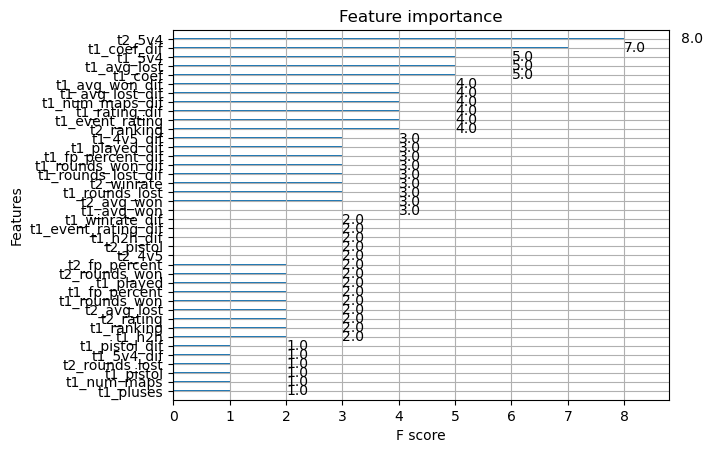

In [26]:
#XGBoost
xgboost.plot_importance(xgb)
plt.show()

In [23]:
#CatBoost
feature_importances = cb.get_feature_importance()
feature_names = cb.feature_names_
importances = sorted(zip(feature_names, feature_importances), key=lambda x: x[1], reverse=True)
print(importances)

[('t1_coef_dif', 14.475957719567893), ('t2_coef', 14.327941603413151), ('t1_avg_lost_dif', 9.736783813390296), ('t1_coef', 7.943344493102026), ('t1_avg_won', 5.216711612633735), ('t1_num_maps', 4.682486149893089), ('t1_winrate_dif', 4.310640657909226), ('t2_event_rating', 4.218671746389398), ('t1_pistol_dif', 3.5370372918602886), ('t2_5v4', 3.314358598796716), ('t2_ranking', 2.7581192884719767), ('t1_fp_percent_dif', 2.736691259357291), ('t2_rounds_won', 2.4251891959319782), ('t1_map_winstreak', 2.420994063317271), ('t2_avg_lost', 2.3247620763989416), ('t1_pluses', 2.2492593106215657), ('t1_map_winstreak_dif', 2.1594757289351016), ('t2_avg_won', 2.0555001163567295), ('t1_event_rating', 1.8079504293468707), ('t2_num_maps', 1.7805307434467084), ('t1_event_rating_dif', 1.7720650211997788), ('t2_played', 1.1888967698705388), ('t1_winrate', 1.0973891607945727), ('t2_pistol', 1.064525401200743), ('t1_pluses_dif', 0.39471774779411495), ('t1_winstreak', 0.0), ('t2_winstreak', 0.0), ('t1_h2h', 

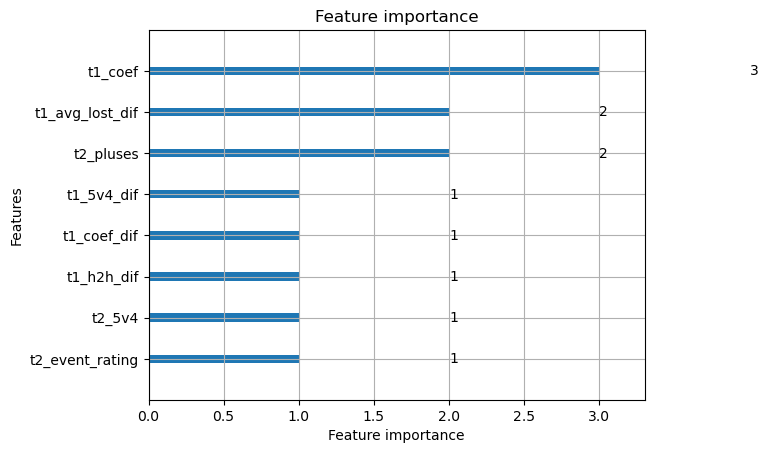

In [24]:
#LightGBM
plot_importance(lgb)
plt.show()

### Experiment 3. Different Data split (Same 100 for test, 10 fold -> 50 for validation) --> No particular effect (Deleted code cells since mainly was just copypasting from previous experiments with minor code changes)

### Experiment 4. Tried to change the eval_metric to logloss --> No particular effect (Deleted code cells since mainly was just copypasting from previous experiments with minor code changes)

### Experiment 5. Feature Selection + experimenting with eval_metric and optuna optimization metric.

#### Select K-best features (k=15)

In [60]:
dataset = pd.read_csv('diffs.csv')
Y = dataset.loc[:,['result']]
X = dataset.drop('result',axis=1)

k_best = SelectKBest(k=15).fit(X,Y.values.ravel())
print(k_best.get_feature_names_out())
X_k = pd.DataFrame(k_best.transform(X), columns=k_best.get_feature_names_out())
print(X_k.shape)

x_train, x_test, y_train, y_test = train_test_split(X_k, Y, test_size=100, shuffle=True, random_state=42)
print(x_train.shape)
print(x_test.shape)

['t1_h2h_dif' 't1_ranking_dif' 't1_pluses_dif' 't1_minuses_dif'
 't1_coef_dif' 't1_rating_dif' 't1_avg_lost_dif' 't1_avg_won_dif'
 't1_rounds_lost_dif' 't1_fp_percent_dif' 't1_winrate_dif' 't1_played_dif'
 't1_map_winstreak_dif' 't1_map_losestreak_dif' 'fp_diff']
(619, 15)
(519, 15)
(100, 15)


##### Modelling

In [61]:
defaults = pd.DataFrame([['XGBoost',0],['CatBoost',0],['LightGBM',0]],columns=['clf_name', 'clf_accuracy'])
models = [XGBClassifier(random_state=random_state), CatBoostClassifier(random_state=random_state, verbose=0), LGBMClassifier(random_state=random_state)]

cv = KFold(n_splits=5)

for index, model in enumerate(models):
    accuracies = []  # List to store the accuracy of each fold
    for train_index, test_index in cv.split(x_train):
        fx_train, fx_test = x_train.iloc[train_index], x_train.iloc[test_index]
        fy_train, fy_test = y_train.iloc[train_index], y_train.iloc[test_index]

        model.fit(fx_train, fy_train.values.ravel())

        preds = model.predict(fx_test)

        if index == 1:
            preds = [True if item=='True' else False for item in model.predict(fx_test)]

        accuracies.append(accuracy_score(fy_test, preds))
    
    mean_accuracy = np.mean(accuracies)
    defaults.loc[index, 'clf_accuracy'] = mean_accuracy

defaults.sort_values(by='clf_accuracy', ascending=False).head()

,clf_name,clf_accuracy
1,CatBoost,0.583682
2,LightGBM,0.554892
0,XGBoost,0.543335


##### Fine-tuning

In [ ]:
#CatBoost
def cb_objective(trial, X, y):
    param_grid = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 50, step=1),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 0, 20, step=1),
        "colsample_bylevel": trial.suggest_float(
            "colsample_bylevel", 0.5, 1, step=0.1
        ),
        "subsample": trial.suggest_float("subsample", 0.5, 1, step=0.1),
        "random_strength": trial.suggest_float("random_strength", 0, 1, step=0.1),
        #"grow_policy": trial.suggest_categorical("grow_policy", ["SymmetricTree"]),
        "bagging_temperature": trial.suggest_float('bagging_temperature', 0, 20, step=0.25)
    }

    cv = KFold(n_splits=5)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = CatBoostClassifier(
                              **param_grid,
                              iterations=10000,
                              loss_function='Logloss',
                              random_seed=42,
                              early_stopping_rounds=50,
                              eval_metric='Logloss',
                              verbose=0
                              )
 
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            verbose=False,
        )
        preds = model.predict_proba(X_test)
        cv_scores[idx] = log_loss(y_test, preds)

    return np.mean(cv_scores)

study = optuna.create_study(direction="minimize", study_name="CB Classifier")
func = lambda trial: cb_objective(trial, x_train, np.ravel(y_train.values))
study.optimize(func, n_trials=200)

print(f"\tBest value : {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

In [ ]:
#XGBoost
def xgb_objective(trial, X, y):
    param_grid = {
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "eta": trial.suggest_float("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_weight": trial.suggest_int("min_child_weight", 0, 10, step=1),
        "reg_lambda": trial.suggest_int("reg_lambda", 0, 20, step=2),
        "reg_alpha": trial.suggest_int("reg_alpha", 0, 20, step=2),
        "gamma": trial.suggest_int("gamma", 0, 10, step=1),
        "colsample_bytree": trial.suggest_float(
            "colsample_bytree", 0.5, 1, step=0.1
        ),
        "subsample": trial.suggest_float("subsample", 0.5, 1, step=0.1),
    }

    cv = KFold(n_splits=5)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = XGBClassifier(objective='binary:logistic', **param_grid, early_stopping_rounds=50, eval_metric="logloss", verbosity=0, n_jobs=4, random_state=42)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            verbose=False,
        )
        preds = model.predict_proba(X_test)
        cv_scores[idx] = log_loss(y_test, preds)

    return np.mean(cv_scores)

study = optuna.create_study(direction="minimize", study_name="XGB Classifier")
func = lambda trial: xgb_objective(trial, x_train, np.ravel(y_train.values))
study.optimize(func, n_trials=200)

print(f"\tBest value: {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

In [ ]:
#LGBClassifier
def lgb_objective(trial, X, y):
    param_grid = {
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 30),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 20),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 20),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.6, 1, step=0.1
        ),
        "bagging_freq": trial.suggest_int("bagging_freq", 5, 50, step=5),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.6, 1, step=0.1
        ),
        "subsample": trial.suggest_float("subsample", 0.6, 1, step=0.1)
    }

    cv = KFold(n_splits=5)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = LGBMClassifier(objective="binary", **param_grid, random_state=42, verbosity=-1, early_stopping_rounds=50)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="logloss",
            verbose=False
        )
        preds = model.predict_proba(X_test)
        cv_scores[idx] = log_loss(y_test, preds)

    return np.mean(cv_scores)

study = optuna.create_study(direction="minimize", study_name="LGBM Classifier")
func = lambda trial: lgb_objective(trial, x_train, np.ravel(y_train.values))
study.optimize(func, n_trials=200)

print(f"\tBest value: {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

##### Finding optimal iterations and testing on test set

In [75]:
#CatBoost
model = CatBoostClassifier(
        learning_rate= 0.17150150582778445,
		max_depth= 3,
        min_data_in_leaf= 29,
		l2_leaf_reg= 17,
		colsample_bylevel= 0.9,
		subsample= 0.7,
		random_strength= 1.0,
		bagging_temperature= 19.5,
        iterations=10000,
        loss_function='Logloss',
        random_seed=42,
        early_stopping_rounds=50,
        eval_metric='Logloss',
        verbose=0
        )

cv = KFold(n_splits=5)
iters = np.empty(5)

for idx, (train_idx, test_idx) in enumerate(cv.split(x_train, y_train)):
    fx_train, fx_test = x_train.iloc[train_idx], x_train.iloc[test_idx]
    fy_train, fy_test = y_train.iloc[train_idx], y_train.iloc[test_idx]

    model.fit(
        fx_train,
        fy_train,
        eval_set=[(fx_test, fy_test)],
        verbose=False,
    )
    iters[idx] = model.get_best_iteration()

cb_iters = np.mean(iters)
print(cb_iters)

32.4


In [76]:
# XGBOOST
model = XGBClassifier(
        objective='binary:logistic', 
        n_estimators=10000,
		learning_rate=0.07209567459064384,
		max_depth=3,
		min_child_weight=2,
		reg_lambda=20,
		reg_alpha=0,
		gamma=2,
		colsample_bytree=0.7,
		subsample=0.7,
        early_stopping_rounds=50,
        eval_metric="logloss",
        verbosity=0,
        n_jobs=4,
        random_state=42
    )

cv = KFold(n_splits=5)
iters = np.empty(5)

for idx, (train_idx, test_idx) in enumerate(cv.split(x_train, y_train)):
    fx_train, fx_test = x_train.iloc[train_idx], x_train.iloc[test_idx]
    fy_train, fy_test = y_train.iloc[train_idx], y_train.iloc[test_idx]

    model.fit(
        fx_train,
        fy_train,
        eval_set=[(fx_test, fy_test)],
        verbose=False,
    )
    iters[idx] = model.best_iteration

xgb_iters = np.mean(iters)
print(xgb_iters)

81.0


In [ ]:
#LGB
model = LGBMClassifier(
        objective="binary", 
        random_state=42, 
        verbosity=-1, 
        early_stopping_rounds=50,
        n_estimators=10000,
		learning_rate=0.0623685938954552,
		num_leaves=900,
		max_depth=3,
		min_data_in_leaf=9,
		lambda_l1=0,
		lambda_l2=15,
		min_gain_to_split=0.9966877386609001,
		bagging_fraction=0.9,
		bagging_freq=30,
		feature_fraction=0.7,
		subsample=0.7
        )

cv = KFold(n_splits=5)
iters = np.empty(5)

for idx, (train_idx, test_idx) in enumerate(cv.split(x_train, y_train)):
    fx_train, fx_test = x_train.iloc[train_idx], x_train.iloc[test_idx]
    fy_train, fy_test = y_train.iloc[train_idx], y_train.iloc[test_idx]

    model.fit(
        fx_train,
        fy_train,
        eval_set=[(fx_test, fy_test)],
        eval_metric="logloss",
        verbose=False,
    )
    iters[idx] = model.best_iteration_

lgb_iters = np.mean(iters)
print(lgb_iters)

In [78]:
xgb = XGBClassifier(
        objective='binary:logistic', 
        n_estimators=81,
		learning_rate=0.07209567459064384,
		max_depth=3,
		min_child_weight=2,
		reg_lambda=20,
		reg_alpha=0,
		gamma=2,
		colsample_bytree=0.7,
		subsample=0.7,
        verbosity=0,
        n_jobs=4,
        random_state=42
    )

xgb.fit(x_train, y_train, verbose=False)
preds = xgb.predict(x_test)
print(accuracy_score(y_test, preds))

0.52


In [79]:
cb = CatBoostClassifier(
        learning_rate= 0.17150150582778445,
		max_depth= 3,
        min_data_in_leaf= 29,
		l2_leaf_reg= 17,
		colsample_bylevel= 0.9,
		subsample= 0.7,
		random_strength= 1.0,
		bagging_temperature= 19.5,
        iterations=32,
        loss_function='Logloss',
        random_seed=42,
        verbose=0
)   

cb.fit(x_train, y_train, verbose=False)
preds = [True if item=='True' else False for item in cb.predict(x_test)]
print(accuracy_score(y_test, preds))

0.54


In [80]:
lgb = LGBMClassifier(
        objective="binary", 
        random_state=42, 
        verbosity=-1, 
        n_estimators=52,
		learning_rate=0.0623685938954552,
		num_leaves=900,
		max_depth=3,
		min_data_in_leaf=9,
		lambda_l1=0,
		lambda_l2=15,
		min_gain_to_split=0.9966877386609001,
		bagging_fraction=0.9,
		bagging_freq=30,
		feature_fraction=0.7,
		subsample=0.7
)

lgb.fit(x_train, y_train.values.ravel())
preds = lgb.predict(x_test)
print(accuracy_score(y_test, preds))

0.56


#### Recursive Feature Selection

##### Find best number of features for base models

In [48]:
import warnings
warnings.filterwarnings("ignore")

dataset = pd.read_csv('diffs.csv')
Y = dataset.loc[:,['result']]
X = dataset.drop('result',axis=1)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=80, shuffle=True, random_state=42)
# x_train, x_rest, y_train, y_rest = train_test_split(X, Y, test_size=160, shuffle=True, random_state=42)
# x_val, x_test, y_val, y_test = train_test_split(x_rest, y_rest, test_size=80, shuffle=True, random_state=42)

xgb = XGBClassifier(
        objective='binary:logistic', 
        random_state=42
    )

cb = CatBoostClassifier(
    loss_function='Logloss',
    random_seed=42,
    verbose=0
)

lgb = LGBMClassifier(
    objective='binary',
    random_state=42,
    verbosity=-1
)
# Select bset # of features

features ={}
for i in range(1,23):
    rfe = RFE(estimator=xgb, n_features_to_select=i)
    rfe.fit(x_train, y_train)
    # print(f'The selected features are: {rfe.get_feature_names_out()}')
    rfe_train = rfe.transform(x_train)
    rfe_test = rfe.transform(x_test)

    xgb.fit(rfe_train, y_train)
    features[i] = accuracy_score(y_test,xgb.predict(rfe_test))

print(f"RFE for xgboost {features}")

####

features ={}
for i in range(1,23):
    rfe = RFE(estimator=cb, n_features_to_select=i)
    rfe.fit(x_train, y_train)
    # print(f'The selected features are: {rfe.get_feature_names_out()}')
    rfe_train = rfe.transform(x_train)
    rfe_test = rfe.transform(x_test)

    cb.fit(rfe_train, y_train)
    features[i] = accuracy_score(y_test,[True if item=="True" else False for item in cb.predict(rfe_test)])

print(f"RFE for catboost {features}")

####

features ={}
for i in range(1,23):
    rfe = RFE(estimator=lgb, n_features_to_select=i)
    rfe.fit(x_train, y_train)
    # print(f'The selected features are: {rfe.get_feature_names_out()}')
    rfe_train = rfe.transform(x_train)
    rfe_test = rfe.transform(x_test)

    lgb.fit(rfe_train, y_train)
    features[i] = accuracy_score(y_test,lgb.predict(rfe_test))

print(f"RFE for lgbm {features}")

########################################################################################

RFE for xgboost {1: 0.5125, 2: 0.5, 3: 0.4625, 4: 0.4625, 5: 0.4625, 6: 0.475, 7: 0.5, 8: 0.575, 9: 0.6, 10: 0.525, 11: 0.525, 12: 0.5625, 13: 0.6375, 14: 0.6, 15: 0.575, 16: 0.55, 17: 0.6125, 18: 0.5625, 19: 0.6, 20: 0.65, 21: 0.5875, 22: 0.5625}
RFE for catboost {1: 0.525, 2: 0.525, 3: 0.55, 4: 0.5375, 5: 0.5, 6: 0.5375, 7: 0.575, 8: 0.525, 9: 0.4875, 10: 0.5125, 11: 0.5, 12: 0.5125, 13: 0.525, 14: 0.5125, 15: 0.5375, 16: 0.5375, 17: 0.55, 18: 0.55, 19: 0.5625, 20: 0.575, 21: 0.5625, 22: 0.5625}
RFE for lgbm {1: 0.55, 2: 0.55, 3: 0.475, 4: 0.6125, 5: 0.575, 6: 0.6, 7: 0.5875, 8: 0.5875, 9: 0.6, 10: 0.6125, 11: 0.6125, 12: 0.5375, 13: 0.5625, 14: 0.5625, 15: 0.55, 16: 0.575, 17: 0.5625, 18: 0.575, 19: 0.6, 20: 0.5625, 21: 0.575, 22: 0.575}


In [16]:
with open('rfe_xgb.pkl', 'rb') as file:
    xgb_rfe = pickle.load(file)
with open('rfe_cb.pkl', 'rb') as file:
    cb_rfe = pickle.load(file)
with open('rfe_lgb.pkl', 'rb') as file:
    lgb_rfe = pickle.load(file)

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

y_train = train.loc[:,'result']
x_train = train.drop('result', axis=1)

y_test = test.loc[:,'result']
x_test = test.drop('result', axis=1)

xgb_train = xgb_rfe.transform(x_train)
xgb_test = xgb_rfe.transform(x_test)
cb_train = cb_rfe.transform(x_train)
cb_test = cb_rfe.transform(x_test)
lgb_train = lgb_rfe.transform(x_train)
lgb_test = lgb_rfe.transform(x_test)

##### Fine-tuning with rfe features

In [ ]:
#fine-tuning for test test
def xgb_objective(trial, x_train, y_train, x_test, y_test):
    param_grid = {
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "eta": trial.suggest_float("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_weight": trial.suggest_int("min_child_weight", 0, 10, step=1),
        "reg_lambda": trial.suggest_int("reg_lambda", 0, 20, step=2),
        "reg_alpha": trial.suggest_int("reg_alpha", 0, 20, step=2),
        "gamma": trial.suggest_int("gamma", 0, 10, step=1),
        # "colsample_bytree": trial.suggest_float(
        #     "colsample_bytree", 0.5, 1, step=0.1
        # ),
        # "subsample": trial.suggest_float("subsample", 0.5, 1, step=0.1)
    }

    
    model = XGBClassifier(objective='binary:logistic', **param_grid, early_stopping_rounds=50, eval_metric="error", verbosity=0, n_jobs=4, random_state=42)
    model.fit(
        x_train,
        y_train,
        eval_set=[(x_test, y_test)],
        verbose=False
    )
    preds = model.predict(x_test)

    return accuracy_score(y_test, preds)

study = optuna.create_study(direction="maximize", study_name="XGB Classifier")
func = lambda trial: xgb_objective(trial, xgb_train, np.ravel(y_train.values), xgb_test, np.ravel(y_test.values))
study.optimize(func, n_trials=300)

print(f"\tBest value: {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

Best value: 0.73750
	Best params:
		n_estimators: 10000
		learning_rate: 0.1778979947018614
		max_depth: 5
		min_child_weight: 2
		reg_lambda: 8
		reg_alpha: 0
		gamma: 0

In [ ]:
#CatBoost
def cb_objective(trial, x_train, y_train, x_val, y_val):
    param_grid = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 50, step=1),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 0, 30, step=1),
        # "colsample_bylevel": trial.suggest_float(
        #     "colsample_bylevel", 0.5, 1, step=0.1
        # ),
        # "subsample": trial.suggest_float("subsample", 0.5, 1, step=0.1),
        "random_strength": trial.suggest_float("random_strength", 0, 1, step=0.1),
        "bagging_temperature": trial.suggest_float('bagging_temperature', 0, 20, step=0.25)
    }

    # pruning = CatBoostPruningCallback(trial, 'Logloss')
    model = CatBoostClassifier(
                            **param_grid,
                            iterations=10000,
                            random_seed=42,
                            verbose=0,
                            eval_metric='Accuracy',
                            early_stopping_rounds=50
                            )

    model.fit(
        x_train,
        y_train,
        eval_set=[(x_val,y_val)],
        verbose=False,
        # callbacks=[pruning]
    )
    preds = [True if item=='True' else False for item in model.predict(x_val)]
    score = accuracy_score(y_val, preds)

    return score

study = optuna.create_study(direction="maximize", study_name="CB Classifier") # pruner=optuna.pruners.MedianPruner(n_warmup_steps=5)
func = lambda trial: cb_objective(trial, cb_train, np.ravel(y_train.values), cb_test, np.ravel(y_test.values))
study.optimize(func, n_trials=300)

print(f"\tBest value : {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

Best value : 0.75000
	Best params:
		learning_rate: 0.2504595028727598
		max_depth: 8
		min_data_in_leaf: 46
		l2_leaf_reg: 10
		random_strength: 0.30000000000000004
		bagging_temperature: 8.0

In [ ]:
def lgb_objective(trial, x_train, y_train, x_val, y_val):
    param_grid = {
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 50),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 20),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 20),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        # "bagging_fraction": trial.suggest_float(
        #     "bagging_fraction", 0.5, 1, step=0.1
        # ),
        "bagging_freq": trial.suggest_int("bagging_freq", 5, 50, step=5),
        # "feature_fraction": trial.suggest_float(
        #     "feature_fraction", 0.5, 1, step=0.1
        # ),
        # "subsample": trial.suggest_float("subsample", 0.5, 1, step=0.1)
    }

    model = LGBMClassifier(objective="binary", **param_grid, random_state=42, verbosity=-1, early_stopping_rounds=50)
    model.fit(
        x_train,
        y_train,
        eval_set=[(x_val, y_val)],
        eval_metric="binary_error",
        verbose=False
    )
    preds = model.predict(x_val)
    score = accuracy_score(y_val, preds)

    return score

study = optuna.create_study(direction="maximize", study_name="LGBM Classifier")
func = lambda trial: lgb_objective(trial, lgb_train, np.ravel(y_train.values), lgb_test, np.ravel(y_test))
study.optimize(func, n_trials=300)

print(f"\tBest value: {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

Best value: 0.61250
	Best params:
		n_estimators: 10000
		learning_rate: 0.20757562320258496
		num_leaves: 460
		max_depth: 9
		min_data_in_leaf: 36
		lambda_l1: 17
		lambda_l2: 0
		min_gain_to_split: 9.612828269699992

##### Saving best models

In [34]:
# XGBOOST
model = XGBClassifier(
        objective='binary:logistic', 
        n_estimators= 10000,
		learning_rate= 0.1778979947018614,
		max_depth= 5,
		min_child_weight=2,
		reg_lambda= 8,
		reg_alpha= 0,
		gamma= 0,
		# colsample_bytree= 0.5,
		# subsample= 0.6,
        early_stopping_rounds=50,
        eval_metric="error",
        verbosity=0,
        n_jobs=4,
        random_state=42
    )


model.fit(
    xgb_train,
    y_train,
    eval_set=[(xgb_test, y_test)],
    verbose=False,
)

print(accuracy_score(y_test, model.predict(xgb_test)))

with open('xgb_rfe20.pkl','wb') as file:
    pickle.dump(model, file)

0.7375


In [37]:
# CatBOOST
cb = CatBoostClassifier(
        learning_rate= 0.2504595028727598,
		max_depth= 8,
		l2_leaf_reg= 10,
        min_data_in_leaf=46,
		random_strength= 0.30000000000000004,
		bagging_temperature= 8.0,
        iterations=10000,
        random_seed=42,
        verbose=0,
        eval_metric='Accuracy',
        early_stopping_rounds=50
)   

cb.fit(cb_train, 
       y_train,
       eval_set=[(cb_test, y_test)],
       verbose=False
       )

preds = [True if item=='True' else False for item in cb.predict(cb_test)]
print(accuracy_score(y_test, preds))

with open('cb_rfe20.pkl','wb') as file:
    pickle.dump(cb, file)

0.75


In [ ]:
# LighGBM
lgb = LGBMClassifier(
        objective="binary", 
        random_state=42, 
        verbosity=-1, 
        n_estimators=10000,
		learning_rate=0.20757562320258496,
		num_leaves=460,
		max_depth=9,
		min_data_in_leaf=36,
		lambda_l1=17,
		lambda_l2=0,
		min_gain_to_split=9.612828269699992,
        early_stopping_rounds=50
)

lgb.fit(lgb_train,
        y_train.values.ravel(),
        eval_set=[(lgb_test, y_test.values.ravel())],
        eval_metric="binary_error",
        verbose=False)

preds = lgb.predict(lgb_test)
print(accuracy_score(y_test, preds))

with open('lgb_rfe20.pkl','wb') as file:
    pickle.dump(lgb, file)

#### PCA

In [17]:
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

y_train = train.loc[:,'result']
x_train = train.drop('result', axis=1)

y_test = test.loc[:,'result']
x_test = test.drop('result', axis=1)

xgb = XGBClassifier(
        objective='binary:logistic', 
        random_state=42
    )

cb = CatBoostClassifier(
    loss_function='Logloss',
    random_seed=42,
    verbose=0
)

lgb = LGBMClassifier(
    objective='binary',
    random_state=42,
    verbosity=-1
)

scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

features = {}

for i in range(1,23):
    pca = PCA(n_components=i)
    pca.fit(x_train)
    pca_train = pca.transform(x_train)
    pca_test = pca.transform(x_test)

    xgb.fit(pca_train, y_train)
    features[i] = accuracy_score(y_test,xgb.predict(pca_test))

print(f"PCA for xgboost {features}")

features = {}
for i in range(1,23):
    pca = PCA(n_components=i)
    pca.fit(x_train)
    pca_train = pca.transform(x_train)
    pca_test = pca.transform(x_test)

    cb.fit(pca_train, y_train)
    features[i] = accuracy_score(y_test,[True if item=="True" else False for item in cb.predict(pca_test)])

print(f"PCA for cboost {features}")

features = {}
for i in range(1,23):
    pca = PCA(n_components=i)
    pca.fit(x_train)
    pca_train = pca.transform(x_train)
    pca_test = pca.transform(x_test)

    lgb.fit(pca_train, y_train)
    features[i] = accuracy_score(y_test,lgb.predict(pca_test))

print(f"PCA for lgboost {features}")

PCA for xgboost {1: 0.5125, 2: 0.5, 3: 0.5, 4: 0.5375, 5: 0.4875, 6: 0.475, 7: 0.575, 8: 0.5125, 9: 0.5125, 10: 0.525, 11: 0.5125, 12: 0.4875, 13: 0.5625, 14: 0.5125, 15: 0.5, 16: 0.5375, 17: 0.5125, 18: 0.4875, 19: 0.5375, 20: 0.5625, 21: 0.5625, 22: 0.6125}
PCA for cboost {1: 0.5375, 2: 0.4625, 3: 0.45, 4: 0.5375, 5: 0.5125, 6: 0.5, 7: 0.5125, 8: 0.5125, 9: 0.4875, 10: 0.5375, 11: 0.525, 12: 0.5375, 13: 0.5375, 14: 0.5125, 15: 0.525, 16: 0.5375, 17: 0.5125, 18: 0.55, 19: 0.5625, 20: 0.525, 21: 0.575, 22: 0.5375}
PCA for lgboost {1: 0.5125, 2: 0.45, 3: 0.4125, 4: 0.5, 5: 0.5375, 6: 0.45, 7: 0.4875, 8: 0.575, 9: 0.5125, 10: 0.55, 11: 0.4875, 12: 0.4625, 13: 0.45, 14: 0.4875, 15: 0.5375, 16: 0.5, 17: 0.5, 18: 0.525, 19: 0.45, 20: 0.475, 21: 0.525, 22: 0.575}
